Loaded 100 samples from ECG/ECG_TRAIN.ts
Loaded 100 samples from ECG/ECG_TEST.ts
Number of classes: 2
y_train unique labels: [0 1]
y_test unique labels: [0 1]
x_train shape: (100, 95)
y_train shape: (100,)
x_test shape: (100, 95)
y_test shape: (100,)


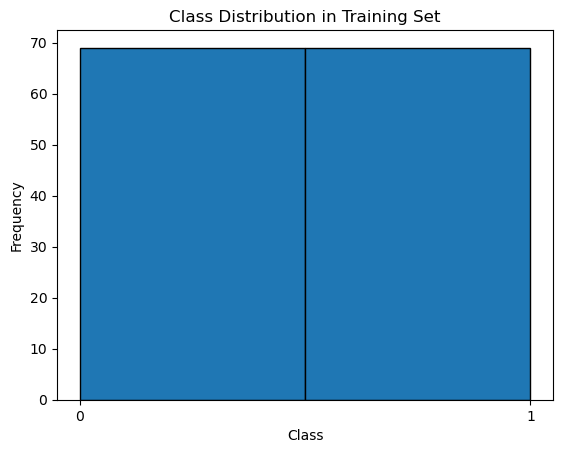

Epoch [1/50] | Loss: 0.6930, Training accuracy: 46.38%
Test Accuracy after Epoch 1: 69.00%
Epoch [2/50] | Loss: 0.6869, Training accuracy: 56.52%
Test Accuracy after Epoch 2: 69.00%
Epoch [3/50] | Loss: 0.6954, Training accuracy: 54.35%
Test Accuracy after Epoch 3: 55.00%
Epoch [4/50] | Loss: 0.6856, Training accuracy: 55.07%
Test Accuracy after Epoch 4: 70.00%
Epoch [5/50] | Loss: 0.6935, Training accuracy: 51.45%
Test Accuracy after Epoch 5: 67.00%
Epoch [6/50] | Loss: 0.6795, Training accuracy: 61.59%
Test Accuracy after Epoch 6: 68.00%
Epoch [7/50] | Loss: 0.6841, Training accuracy: 60.87%
Test Accuracy after Epoch 7: 67.00%
Epoch [8/50] | Loss: 0.6870, Training accuracy: 57.25%
Test Accuracy after Epoch 8: 63.00%
Epoch [9/50] | Loss: 0.6897, Training accuracy: 56.52%
Test Accuracy after Epoch 9: 64.00%
Epoch [10/50] | Loss: 0.6849, Training accuracy: 60.14%
Test Accuracy after Epoch 10: 67.00%
Epoch [11/50] | Loss: 0.6868, Training accuracy: 55.80%
Test Accuracy after Epoch 11: 65

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read UCR Dataset
def read_ucr(filename):
    data = []
    labels = []
    
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) < 2:  # Ensure there's at least one feature and one label
                continue
            features = [float(f) for f in parts[:-1]]
            label = int(parts[-1].split(':')[-1])  # Handle label after the colon
            data.append(features)
            labels.append(label)
    
    print(f"Loaded {len(data)} samples from {filename}")
    return np.array(data), np.array(labels)

train_file = 'ECG/ECG_TRAIN.ts'
test_file = 'ECG/ECG_TEST.ts'

# Load dataset
x_train, y_train = read_ucr(train_file)
x_test, y_test = read_ucr(test_file)

# Normalize labels to be within range [0, num_classes-1]
unique_labels = np.unique(y_train)
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y_train = np.array([label_map[label] for label in y_train])
y_test = np.array([label_map[label] for label in y_test])

nb_classes = len(unique_labels)

# Verify labels are within range
print(f"Number of classes: {nb_classes}")
print(f"y_train unique labels: {np.unique(y_train)}")
print(f"y_test unique labels: {np.unique(y_test)}")

# Ensure labels are within the expected range [0, num_classes-1]
assert y_train.min() >= 0 and y_train.max() < nb_classes, "Train labels are out of range"
assert y_test.min() >= 0 and y_test.max() < nb_classes, "Test labels are out of range"

# Print shapes to ensure they match
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Apply SMOTE to the training data
smote = SMOTE()
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Convert to PyTorch tensors
X_train = torch.tensor(x_train_resampled, dtype=torch.float32).unsqueeze(-1)  # Add feature dimension
X_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train_resampled, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create Data Loaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Plot class distribution
plt.hist(y_train.numpy(), bins=nb_classes, edgecolor='k')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(nb_classes))
plt.show()

# Define the LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.5):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Initialize the LSTM model
input_dim = 1  # Since each time step has a single feature
hidden_dim = 32
num_layers = 2
dropout = 0.7
num_classes = nb_classes
model = SimpleLSTM(input_dim, hidden_dim, num_layers, num_classes, dropout).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)  # Reduced learning rate
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Training loop with early stopping
num_epochs = 50
best_test_accuracy = 0
patience = 10
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f}, Training accuracy: {epoch_accuracy:.2f}%')

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f'Test Accuracy after Epoch {epoch+1}: {test_accuracy:.2f}%')
    scheduler.step()

    # Check for early stopping
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

print(f'Best Test Accuracy: {best_test_accuracy:.2f}%')
